In [1]:
import pyeem
import numpy as np
import scipy
from scipy.integrate import trapz
import pandas as pd
import matplotlib.pyplot as plt
"""
# Download a demo dataset from S3
demo_data_dir = pyeem.datasets.download_demo(
    "demo_data", demo_name="rutherford"
)
"""
demo_data_dir = "demo_data/rutherford"
cal_sources = {"cigarette": "ug/ml", "diesel": "ug/ml", "wood_smoke": "ug/ml"}
dataset = pyeem.datasets.Load(
    data_dir=demo_data_dir,
    raman_instrument=None,
    absorbance_instrument="aqualog",
    eem_instrument="aqualog",
    calibration_sources=cal_sources,
    progress_bar=False,
    mode="w"
)
#from pyeem.instruments.agilent import CaryEclipse
#eem_df = CaryEclipse.load_eem("3d_500.csv")

In [2]:
display(dataset.meta_df)

datetime_utc         filename collected_by  \
sample_set scan_type                                                      
1          blank_eem  2020-07-01 10:29:05   blank_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:06  sample_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:07  sample_eem2.csv           JR   
           sample_eem 2020-07-01 10:29:08  sample_eem3.csv           JR   
           sample_eem 2020-07-01 10:29:09  sample_eem4.csv           JR   
...                                   ...              ...          ...   
16         sample_eem 2020-07-01 10:32:57  sample_eem1.csv           JR   
           absorb     2020-07-01 10:32:58      absorb1.csv           JR   
17         blank_eem  2020-07-01 10:32:59   blank_eem1.csv           JR   
           blank_eem  2020-07-01 10:33:00   blank_eem2.csv           JR   
           blank_eem  2020-07-01 10:33:01   blank_eem3.csv           JR   

                                                  description  \
sample_set scan_type                                            
1          blank_eem                 Spectroscopy Grade Blank   
           sample_eem                                 Diesel1   
           sample_eem                                 Diesel2   
           sample_eem                                 Diesel3   
           sample_eem       Cigarette from Cookstove Lab Hood   
...                                                       ...   
16         sample_eem            Cookstove 5 µg/mL (ZEF00136)   
           absorb                                               
17         blank_eem                 Process Blank (ZEF 0143)   
           blank_eem                 Process Blank (ZEF 0146)   
           blank_eem   2018-10-26 Cyclohexane Blank (0.5 sec)   

                                                                comments  \
sample_set scan_type                                                       
1          blank_eem   Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
...                                                                  ...   
16         sample_eem                       0.1 second integration time    
           absorb                                                          
17         blank_eem                                                       
           blank_eem                                                       
           blank_eem                                                       

                       dilution  Raman_Area  cigarette  diesel  wood_smoke  \
sample_set scan_type                                                         
1          blank_eem        1.0   2040.3794       0.00     0.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.77     0.0         0.0   
...                         ...         ...        ...     ...         ...   
16         sample_eem       1.0    267.1000       0.00     0.0         5.0   
           absorb           1.0         NaN       0.00     0.0         5.0   
17         blank_eem        1.0   1311.5000       0.00     0.0         0.0   
           blank_eem        1.0   1311.5000       0.00     0.0         0.0   
           blank_eem        1.0   1311.5000       0.00     0.0         0.0   

                       calibration_sample  prototypical_sample  test_sample  \
sample_set scan_type                                                          
1          blank_eem                False    

## Raman Norm

In [ ]:
from scipy.signal import find_peaks
f = "demo_data/drEEM/raw_sample_sets/1/water_raman1.csv"
water_raman = pd.read_csv(
    f,
    sep=",",
    index_col=0,
    skiprows=1,
    names=["emission_wavelength", "intensity"],
)
water_raman = water_raman.sort_index()
x = water_raman["intensity"]
rng = x.index.max() - x.index.min()
peaks, properties = find_peaks(x, distance=rng, prominence=1, width=1)

display(x.index[peaks], x[x.index[peaks]])
plt.plot(x)
plt.plot(x.index[peaks], x[x.index[peaks]], "x")
plt.vlines(x=x.index[peaks], ymin=x[x.index[peaks]] - properties["prominences"],
           ymax =x[x.index[peaks]], color = "C1")
plt.show()

In [ ]:
import warnings

def raman_normalization(eem_df, water_raman_source, water_raman_df, raman_peak_area=None, method="gradient"):
    # TODO - The Raman area is calculated using the  baseline-corrected
    # peak boundary definition (Murphy and others, 2011)
    # raman_sources = ['water_raman', 'blank', 'metadata']

    if water_raman_source == "water_raman":
        a = 371  # lower limit
        b = 428  # upper limit
        raman_peak_area = trapz(water_raman_df[350].loc[a:b])

    elif water_raman_source == "blank":
        a = 371  # lower limit
        b = 428  # upper limit
        raman_peak_area = trapz(water_raman_df[350].loc[a:b])

    elif water_raman_source == "metadata":
        pass

    else:
        raise KeyError("Invalid water_raman_source.")
        
    norm_eem_df = eem_df / raman_peak_area

    return norm_eem_df


In [ ]:
from pyeem.instruments.horiba import Fluorolog
eem_df = Fluorolog.load_eem("demo_data/drEEM/raw_sample_sets/1/sample_eem1.csv") 
raman_df = Fluorolog.load_eem("demo_data/drEEM/raw_sample_sets/1/water_raman1.csv")
raman_df.plot()

In [ ]:
t = dataset.meta_df.loc[1,"sample_eem"]

raman_norm = "metadata"
raman_area = t[t["filename"] == "sample_eem1.csv"]["Raman_Area"].item()
print(raman_area)
eem_df = pd.read_hdf(dataset.hdf, key=t[t["filename"] == "sample_eem1.csv"]["hdf_path"].item())
display(eem_df)

df = raman_normalization(eem_df, water_raman_source="metadata", water_raman_df=None, raman_peak_area=raman_area)
display(eem_df)
fig, ax = plt.subplots()
ax.imshow(df)
plt.gca().invert_yaxis()
plt.show()

## Augmentations

In [3]:
# Run the preprocessing routine which includes several
# filtering and correction steps.
routine_df = pyeem.preprocessing.create_routine(
    crop=True,
    discrete_wavelengths=False,
    gaussian_smoothing=False,
    blank_subtraction=True,
    inner_filter_effect=False,
    raman_normalization=False,
    scatter_removal=False,
    dilution=False,
)
display(dataset.meta_df)
# discrete_ex_wl = [225, 240, 275, 290, 300, 425]
crop_dimensions = {"emission_bounds": (246, 573), "excitation_bounds": (224, np.inf)}
routine_results_df = pyeem.preprocessing.perform_routine(
    dataset,
    routine_df,
    crop_dims=crop_dimensions,
    raman_norm="metadata",
    progress_bar=False,
)
display(dataset.meta_df)

datetime_utc         filename collected_by  \
sample_set scan_type                                                      
1          blank_eem  2020-07-01 10:29:05   blank_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:06  sample_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:07  sample_eem2.csv           JR   
           sample_eem 2020-07-01 10:29:08  sample_eem3.csv           JR   
           sample_eem 2020-07-01 10:29:09  sample_eem4.csv           JR   
...                                   ...              ...          ...   
16         sample_eem 2020-07-01 10:32:57  sample_eem1.csv           JR   
           absorb     2020-07-01 10:32:58      absorb1.csv           JR   
17         blank_eem  2020-07-01 10:32:59   blank_eem1.csv           JR   
           blank_eem  2020-07-01 10:33:00   blank_eem2.csv           JR   
           blank_eem  2020-07-01 10:33:01   blank_eem3.csv           JR   

                                                  description  \
sample_set scan_type                                            
1          blank_eem                 Spectroscopy Grade Blank   
           sample_eem                                 Diesel1   
           sample_eem                                 Diesel2   
           sample_eem                                 Diesel3   
           sample_eem       Cigarette from Cookstove Lab Hood   
...                                                       ...   
16         sample_eem            Cookstove 5 µg/mL (ZEF00136)   
           absorb                                               
17         blank_eem                 Process Blank (ZEF 0143)   
           blank_eem                 Process Blank (ZEF 0146)   
           blank_eem   2018-10-26 Cyclohexane Blank (0.5 sec)   

                                                                comments  \
sample_set scan_type                                                       
1          blank_eem   Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
...                                                                  ...   
16         sample_eem                       0.1 second integration time    
           absorb                                                          
17         blank_eem                                                       
           blank_eem                                                       
           blank_eem                                                       

                       dilution  Raman_Area  cigarette  diesel  wood_smoke  \
sample_set scan_type                                                         
1          blank_eem        1.0   2040.3794       0.00     0.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.77     0.0         0.0   
...                         ...         ...        ...     ...         ...   
16         sample_eem       1.0    267.1000       0.00     0.0         5.0   
           absorb           1.0         NaN       0.00     0.0         5.0   
17         blank_eem        1.0   1311.5000       0.00     0.0         0.0   
           blank_eem        1.0   1311.5000       0.00     0.0         0.0   
           blank_eem        1.0   1311.5000       0.00     0.0         0.0   

                       calibration_sample  prototypical_sample  test_sample  \
sample_set scan_type                                                          
1          blank_eem                False    

raw_sample_sets/1/sample_eem1
raw_sample_sets/1/sample_eem2
raw_sample_sets/1/sample_eem3
raw_sample_sets/1/sample_eem4
raw_sample_sets/1/sample_eem5
raw_sample_sets/1/sample_eem6
raw_sample_sets/2/sample_eem1
raw_sample_sets/3/sample_eem1
raw_sample_sets/3/sample_eem2
raw_sample_sets/5/sample_eem1
raw_sample_sets/5/sample_eem2
raw_sample_sets/7/sample_eem1
raw_sample_sets/7/sample_eem2
raw_sample_sets/9/sample_eem1
raw_sample_sets/9/sample_eem2
raw_sample_sets/9/sample_eem3
raw_sample_sets/9/sample_eem4
raw_sample_sets/9/sample_eem5
raw_sample_sets/9/sample_eem6
raw_sample_sets/9/sample_eem7
raw_sample_sets/10/sample_eem12
raw_sample_sets/10/sample_eem11
raw_sample_sets/10/sample_eem10
raw_sample_sets/10/sample_eem9
raw_sample_sets/10/sample_eem8
raw_sample_sets/10/sample_eem1
raw_sample_sets/10/sample_eem6
raw_sample_sets/10/sample_eem5
raw_sample_sets/10/sample_eem4
raw_sample_sets/10/sample_eem3
raw_sample_sets/10/sample_eem2
raw_sample_sets/10/sample_eem7
raw_sample_sets/11/sample

datetime_utc         filename collected_by  \
sample_set scan_type                                                      
1          blank_eem  2020-07-01 10:29:05   blank_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:06  sample_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:07  sample_eem2.csv           JR   
           sample_eem 2020-07-01 10:29:08  sample_eem3.csv           JR   
           sample_eem 2020-07-01 10:29:09  sample_eem4.csv           JR   
...                                   ...              ...          ...   
16         sample_eem 2020-07-01 10:32:57  sample_eem1.csv           JR   
           absorb     2020-07-01 10:32:58      absorb1.csv           JR   
17         blank_eem  2020-07-01 10:32:59   blank_eem1.csv           JR   
           blank_eem  2020-07-01 10:33:00   blank_eem2.csv           JR   
           blank_eem  2020-07-01 10:33:01   blank_eem3.csv           JR   

                                                  description  \
sample_set scan_type                                            
1          blank_eem                 Spectroscopy Grade Blank   
           sample_eem                                 Diesel1   
           sample_eem                                 Diesel2   
           sample_eem                                 Diesel3   
           sample_eem       Cigarette from Cookstove Lab Hood   
...                                                       ...   
16         sample_eem            Cookstove 5 µg/mL (ZEF00136)   
           absorb                                               
17         blank_eem                 Process Blank (ZEF 0143)   
           blank_eem                 Process Blank (ZEF 0146)   
           blank_eem   2018-10-26 Cyclohexane Blank (0.5 sec)   

                                                                comments  \
sample_set scan_type                                                       
1          blank_eem   Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
...                                                                  ...   
16         sample_eem                       0.1 second integration time    
           absorb                                                          
17         blank_eem                                                       
           blank_eem                                                       
           blank_eem                                                       

                       dilution  Raman_Area  cigarette  diesel  wood_smoke  \
sample_set scan_type                                                         
1          blank_eem        1.0   2040.3794       0.00     0.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.77     0.0         0.0   
...                         ...         ...        ...     ...         ...   
16         sample_eem       1.0    267.1000       0.00     0.0         5.0   
           absorb           1.0         NaN       0.00     0.0         5.0   
17         blank_eem        1.0   1311.5000       0.00     0.0         0.0   
           blank_eem        1.0   1311.5000       0.00     0.0         0.0   
           blank_eem        1.0   1311.5000       0.00     0.0         0.0   

                       calibration_sample  prototypical_sample  test_sample  \
sample_set scan_type                                                          
1          blank_eem                False    

In [4]:
display(dataset.meta_df)
display(routine_df)
display(routine_results_df.xs(1, level="sample_set"))
display(routine_results_df.xs("complete", level="step_name"))
cal_df = pyeem.preprocessing.calibration(dataset, routine_results_df)
display(cal_df)

datetime_utc         filename collected_by  \
sample_set scan_type                                                      
1          blank_eem  2020-07-01 10:29:05   blank_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:06  sample_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:07  sample_eem2.csv           JR   
           sample_eem 2020-07-01 10:29:08  sample_eem3.csv           JR   
           sample_eem 2020-07-01 10:29:09  sample_eem4.csv           JR   
...                                   ...              ...          ...   
16         sample_eem 2020-07-01 10:32:57  sample_eem1.csv           JR   
           absorb     2020-07-01 10:32:58      absorb1.csv           JR   
17         blank_eem  2020-07-01 10:32:59   blank_eem1.csv           JR   
           blank_eem  2020-07-01 10:33:00   blank_eem2.csv           JR   
           blank_eem  2020-07-01 10:33:01   blank_eem3.csv           JR   

                                                  description  \
sample_set scan_type                                            
1          blank_eem                 Spectroscopy Grade Blank   
           sample_eem                                 Diesel1   
           sample_eem                                 Diesel2   
           sample_eem                                 Diesel3   
           sample_eem       Cigarette from Cookstove Lab Hood   
...                                                       ...   
16         sample_eem            Cookstove 5 µg/mL (ZEF00136)   
           absorb                                               
17         blank_eem                 Process Blank (ZEF 0143)   
           blank_eem                 Process Blank (ZEF 0146)   
           blank_eem   2018-10-26 Cyclohexane Blank (0.5 sec)   

                                                                comments  \
sample_set scan_type                                                       
1          blank_eem   Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
...                                                                  ...   
16         sample_eem                       0.1 second integration time    
           absorb                                                          
17         blank_eem                                                       
           blank_eem                                                       
           blank_eem                                                       

                       dilution  Raman_Area  cigarette  diesel  wood_smoke  \
sample_set scan_type                                                         
1          blank_eem        1.0   2040.3794       0.00     0.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.77     0.0         0.0   
...                         ...         ...        ...     ...         ...   
16         sample_eem       1.0    267.1000       0.00     0.0         5.0   
           absorb           1.0         NaN       0.00     0.0         5.0   
17         blank_eem        1.0   1311.5000       0.00     0.0         0.0   
           blank_eem        1.0   1311.5000       0.00     0.0         0.0   
           blank_eem        1.0   1311.5000       0.00     0.0         0.0   

                       calibration_sample  prototypical_sample  test_sample  \
sample_set scan_type                                                          
1          blank_eem                False    

,step_name,hdf_path
step_order,,
0,raw,raw_sample_sets/
1,crop,preprocessing/filters/crop
2,blank_subtraction,preprocessing/corrections/blank_subtraction
3,complete,preprocessing/complete/


step_completed step_exception  \
scan_type  name        step_name                                         
blank_eem  blank_eem1  raw                         True           None   
                       crop                        True           None   
sample_eem sample_eem1 raw                         True           None   
                       crop                        True           None   
                       blank_subtraction           True           None   
                       complete                    True           None   
           sample_eem2 raw                         True           None   
                       crop                        True           None   
                       blank_subtraction           True           None   
                       complete                    True           None   
           sample_eem3 raw                         True           None   
                       crop                        True           None   
                       blank_subtraction           True           None   
                       complete                    True           None   
           sample_eem4 raw                         True           None   
                       crop                        True           None   
                       blank_subtraction           True           None   
                       complete                    True           None   
           sample_eem5 raw                         True           None   
                       crop                        True           None   
                       blank_subtraction           True           None   
                       complete                    True           None   
           sample_eem6 raw                         True           None   
                       crop                        True           None   
                       blank_subtraction           True           None   
                       complete                    True           None   

                                                                                   hdf_path  
scan_type  name        step_name                                                             
blank_eem  blank_eem1  raw                                     raw_sample_sets/1/blank_eem1  
                       crop                         preprocessing/filters/crop/1/blank_eem1  
sample_eem sample_eem1 raw                                    raw_sample_sets/1/sample_eem1  
                       crop                        preprocessing/filters/crop/1/sample_eem1  
                       blank_subtraction  preprocessing/corrections/blank_subtraction/1/...  
                       complete                        preprocessing/complete/1/sample_eem1  
           sample_eem2 raw                                    raw_sample_sets/1/sample_eem2  
                       crop                        preprocessing/filters/crop/1/sample_eem2  
                       blank_subtraction  preprocessing/corrections/blank_subtraction/1/...  
                       complete                        preprocessing/complete/1/sample_eem2  
           sample_eem3 raw                                    raw_sample_sets/1/sample_eem3  
                       crop                        preprocessing/filters/crop/1/sample_eem3  
                       blank_subtraction  preprocessing/corrections/blank_subtraction/1/...  
                       complete                        preprocessing/complete/1/sample_eem3  
           sample_eem4 raw                                    raw_sample_sets/1/sample_eem4  
                       crop                        preprocessing/filters/crop/1/sample_eem4  
                       blank_subtraction  preprocessing/corrections/blank_subtraction/1/...  
                       complete                        preprocessing/complete/1/sample_eem4  
           sample_eem5 raw                                    raw_sample_sets/1/sample_e

step_completed step_exception  \
sample_set scan_type  name                                         
1          sample_eem sample_eem1            True           None   
                      sample_eem2            True           None   
                      sample_eem3            True           None   
                      sample_eem4            True           None   
                      sample_eem5            True           None   
...                                           ...            ...   
15         sample_eem sample_eem4            True           None   
                      sample_eem3            True           None   
                      sample_eem2            True           None   
                      sample_eem10           True           None   
16         sample_eem sample_eem1            True           None   

                                                                  hdf_path  
sample_set scan_type  name                                                  
1          sample_eem sample_eem1     preprocessing/complete/1/sample_eem1  
                      sample_eem2     preprocessing/complete/1/sample_eem2  
                      sample_eem3     preprocessing/complete/1/sample_eem3  
                      sample_eem4     preprocessing/complete/1/sample_eem4  
                      sample_eem5     preprocessing/complete/1/sample_eem5  
...                                                                    ...  
15         sample_eem sample_eem4    preprocessing/complete/15/sample_eem4  
                      sample_eem3    preprocessing/complete/15/sample_eem3  
                      sample_eem2    preprocessing/complete/15/sample_eem2  
                      sample_eem10  preprocessing/complete/15/sample_eem10  
16         sample_eem sample_eem1    preprocessing/complete/16/sample_eem1  

[107 rows x 3 columns]

concentration  \
source     units slope        intercept     r_squared                  
cigarette  ug/ml 3.050334e+07 -4.036818e+06 0.861951            0.77   
                                            0.861951            5.00   
                                            0.861951            5.00   
                                            0.861951            5.00   
                                            0.861951            5.00   
...                                                              ...   
wood_smoke ug/ml 2.594447e+07 -6.327464e+06 0.364960            0.50   
                                            0.364960            0.50   
                                            0.364960            2.00   
                                            0.364960            1.00   
                                            0.364960            5.00   

                                                       integrated_intensity  \
source     units slope        intercept     r_squared                         
cigarette  ug/ml 3.050334e+07 -4.036818e+06 0.861951           3.823517e+07   
                                            0.861951           2.091132e+08   
                                            0.861951           1.672657e+08   
                                            0.861951           1.830093e+08   
                                            0.861951           1.485089e+08   
...                                                                     ...   
wood_smoke ug/ml 2.594447e+07 -6.327464e+06 0.364960           1.173040e+07   
                                            0.364960          -1.458906e+06   
                                            0.364960           1.113105e+07   
                                            0.364960           4.924516e+06   
                                            0.364960           2.524818e+07   

                                                       prototypical_sample  \
source     units slope        intercept     r_squared                        
cigarette  ug/ml 3.050334e+07 -4.036818e+06 0.861951                 False   
                                            0.861951                  True   
                                            0.861951                  True   
                                            0.861951                 False   
                                            0.861951                 False   
...                                                                    ...   
wood_smoke ug/ml 2.594447e+07 -6.327464e+06 0.364960                 False   
                                            0.364960                 False   
                                            0.364960                 False   
                                            0.364960                 False   
                                            0.364960                  True   

                                                                                     hdf_path  
source     units slope        intercept     r_squared                                          
cigarette  ug/ml 3.050334e+07 -4.036818e+06 0.861951     preprocessing/complete/1/sample_eem4  
                                            0.861951     preprocessing/complete/1/sample_eem5  
                                            0.861951     preprocessing/complete/1/sample_eem6  
                                            0.861951     preprocessing/complete/7/sample_eem1  
                                            0.861951     preprocessing/complete/9/sample_eem1  
...                                                                                       ...  
wood_smoke ug/ml 2.594447e+07 -6.327464e+06 0.364960   preprocessing/complete/15/sample_eem17  
                                            0.364960    preprocessing/complete/15/sample_eem1  
                                            0.364960    preprocessing/complete/15/sample_eem3  
                   

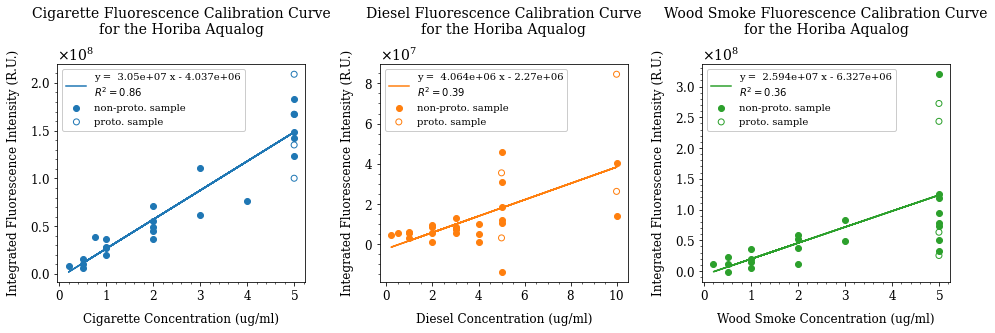

In [5]:
pyeem.plots.plot_calibration_curves(dataset, cal_df)
#pyeem.preprocessing.calibration_summary_info(cal_df)

In [ ]:
results_df = pyeem.augmentation.create_prototypical_spectra(dataset, cal_df)
pyeem.plots.augmentations.plot_prototypical_spectra(
    dataset, results_df, plot_type="surface"
)

In [ ]:
results_df = pyeem.augmentation.create_single_source_spectra(
    dataset, cal_df, conc_range=(0, 5), num_spectra=100
)
display(results_df)

In [ ]:
from IPython.display import HTML
plt.rcParams['figure.dpi'] = 100
%matplotlib inline
anim = pyeem.plots.single_source_animation(dataset, results_df, source="cigarette")
HTML(anim.to_html5_video())

In [ ]:
anim = pyeem.plots.single_source_animation(dataset, results_df, source="diesel")
HTML(anim.to_html5_video())

In [ ]:
anim = pyeem.plots.single_source_animation(dataset, results_df, source="wood_smoke")
HTML(anim.to_html5_video())

In [ ]:
results_df = pyeem.augmentation.create_mixtures(dataset, cal_df, conc_range=(0.01, 6.3), num_steps=5)

In [ ]:
anim = pyeem.plots.mix_animation(dataset, results_df)
HTML(anim.to_html5_video())

In [ ]:
demo_data_dir = "demo_data/qinmin"
dataset = pyeem.datasets.Load(
    data_dir=demo_data_dir,
    raman_instrument=None,
    absorbance_instrument="cary_eclipse",
    eem_instrument="cary_eclipse",
    progress_bar=False,
    mode="w"
)

In [ ]:
display(dataset.meta_df)

In [ ]:
eem_dfs = []
min_val, max_val = np.inf, -np.inf
for hdf_path in dataset.meta_df["hdf_path"]:
    eem_df = pd.read_hdf(dataset.hdf, key=hdf_path)
    
    if max_val < eem_df.dropna().values.max():
        max_val = eem_df.dropna().values.max()
    if min_val > eem_df.dropna().values.min():
        min_val = eem_df.dropna().values.min()

    eem_dfs.append(eem_df)

units="nm"
eem_xlabel = "Excitation " + r"$\lambda$" + " ({0})".format(units)
eem_ylabel = "Emission " + r"$\lambda$" + " ({0})".format(units)
cbar_label = "Normalized Intensity (Raman Units, R.U.)"
cbar_fontsize = 18
for eem_df in eem_dfs:
    fig, ax = plt.subplots(figsize=(5,5))
    plt.xlabel(eem_xlabel)
    plt.ylabel(eem_ylabel)
    plt.tick_params(axis="both", which="major")
    excitation_wavelengths = eem_df.columns.to_numpy().astype(float)
    emission_wavelengths = eem_df.index.to_numpy()
    extent = [
        excitation_wavelengths[0], excitation_wavelengths[-1],
        emission_wavelengths[0], emission_wavelengths[-1]
    ]
    hmap = ax.imshow(
        eem_df, origin="lower", extent=extent, vmin=min_val, vmax=max_val
    )
    ax.set_xlim(xmin=400, xmax=700)
    ax.set_ylim(ymin=400, ymax=800)
    cbar = fig.colorbar(hmap, ax=ax)
    cbar.set_label("Intensity (A.U.)", size=16)
    cbar.ax.tick_params(labelsize=14)
    title_str = "Qinmin's Raw Chlorophyll EEM\n"
    title_str += "Collected w/ MIT Nano's Agilent Cary Eclipse"
    plt.title(title_str, size=14)
    plt.show()